# **House Value Prediction using Deep MLP and Keras Tuner**

This notebook implements Deep MLP using Keras to perform regression task to predict house price based on the California housing dataset from sklearn.

The contents of the notebook are:

  1. Data Preparation and Exploration
  2. Scaling and Modelling
  3. Hyperparameter tuning using Keras Tuner

### **Load and study the data**

In [1]:
#import libraries
import IPython
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LeakyReLU, AlphaDropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#load the data
california_data = fetch_california_housing()

In [3]:
#print the data description
print(california_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

This shows there are 8 input features and the number of instances is 20640. There are no missing values and thus data cleaning is not required to be performed. The target feature is the median house value.

In [4]:
#create a data frame from the input features
california_df = pd.DataFrame(data = california_data.data, columns = california_data.feature_names)

#add the target feature to the df
california_df['MedHouseValue'] = california_data.target

In [5]:
#check for the data
california_df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


In [6]:
california_df.tail(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [7]:
california_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


This shows the max Median house value is 5.00 and min is 0.149. It also gives the statistics of the other numerical features present in the data.

### **Data exploration**

[Text(0, 0.5, 'Density')]

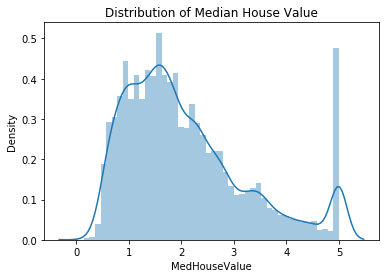

In [8]:
#check the distribution of the target feature
ax = sns.distplot(california_df['MedHouseValue'])
ax.set_title("Distribution of Median House Value")
ax.set(ylabel = "Density")

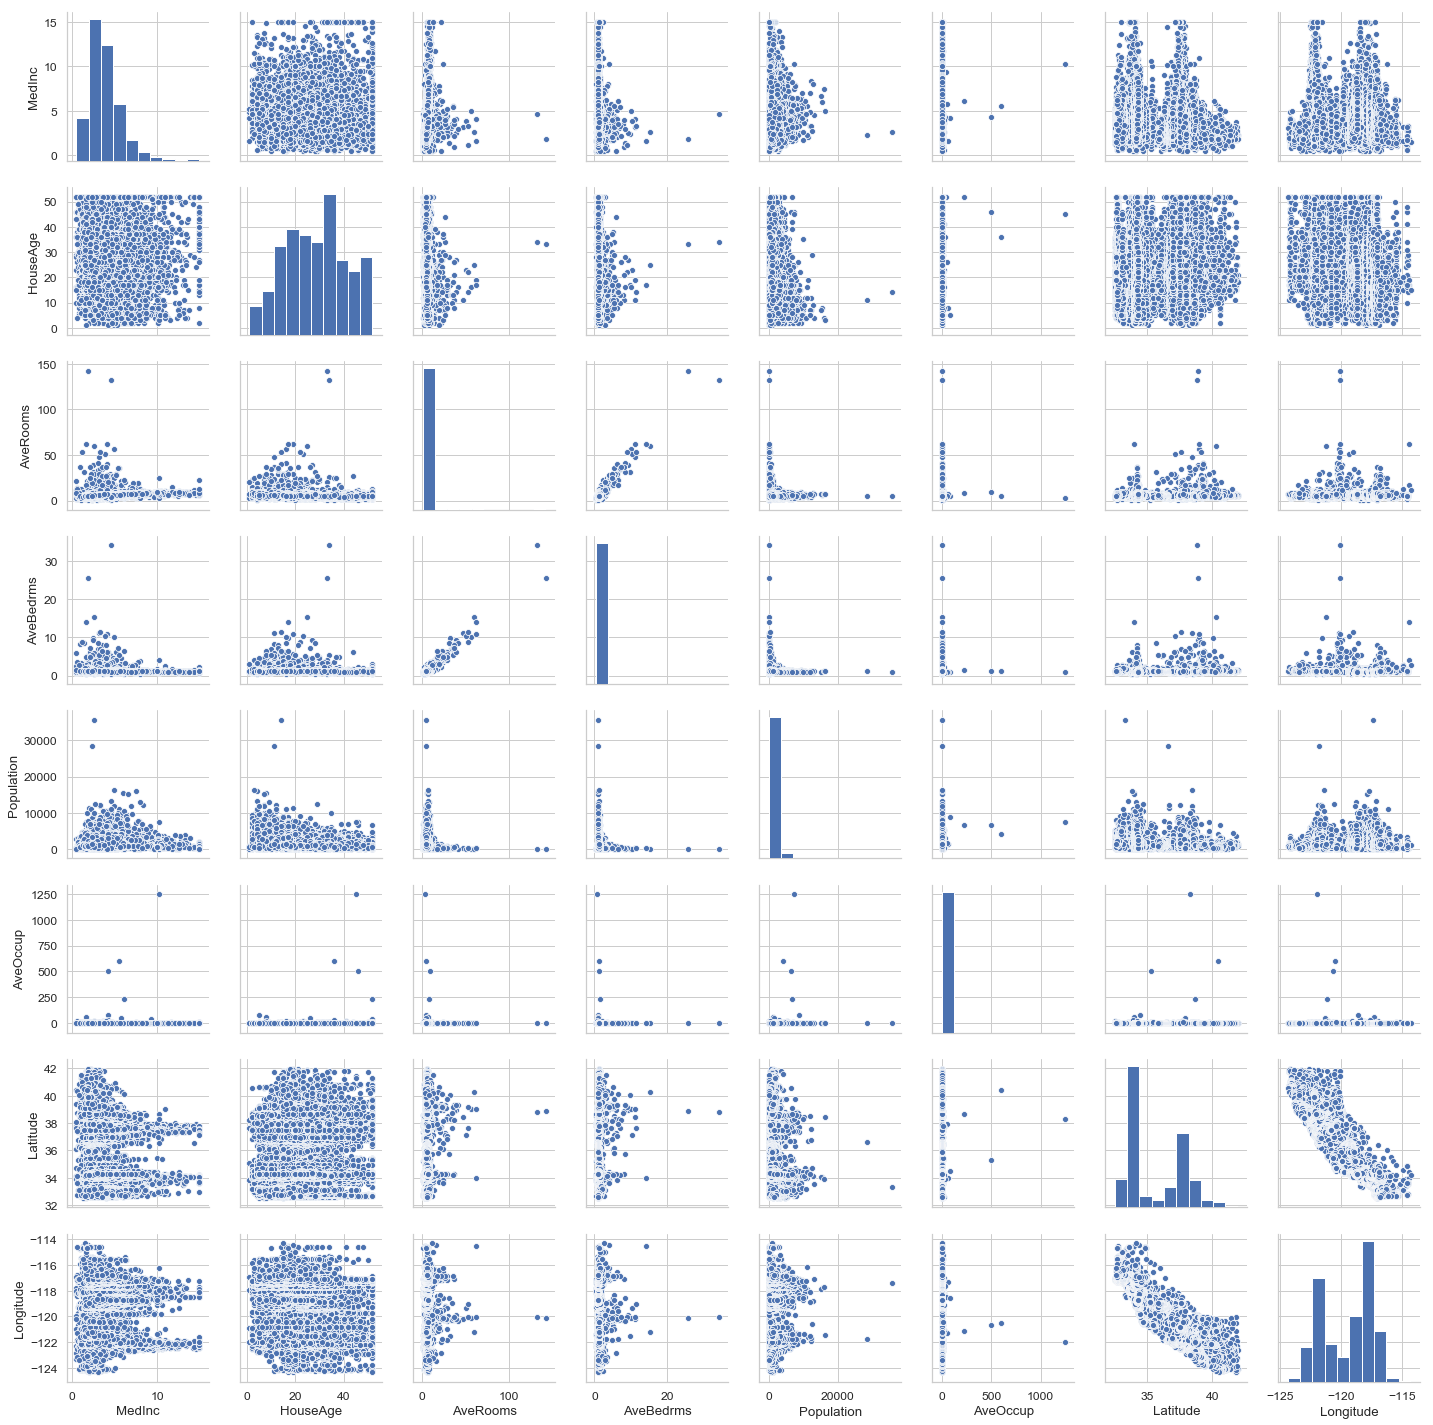

In [9]:
#plot pair plot to see the histogram and the distribution of the attributes and their realionship with other features
sns.set(font_scale = 1.1)
sns.set_style('whitegrid')
grid = sns.pairplot(data=california_df, vars=california_df.columns[0:8])

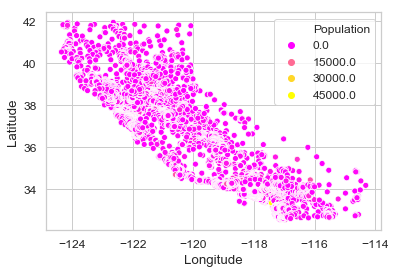

In [10]:
#show the map of california using longitude, latitude and see population across the state
sns.scatterplot("Longitude", "Latitude", data = california_df, hue = "Population", palette = "spring")

This above plot shows the map of California plotted with Longitude and Latitude. The houses distribution is plotted based on the population count.

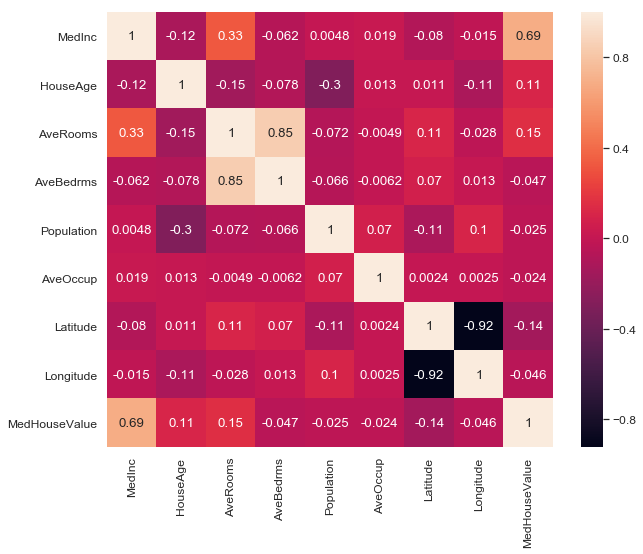

In [11]:
#plot the heat map to check the correlation between the features
ax1 = sns.heatmap(california_df.corr(), annot = True)
ax1.figure.set_size_inches(10,8)

This shows MedInc has high correlation and Longitude has the least correlation with the target feature: MedHouseValue.

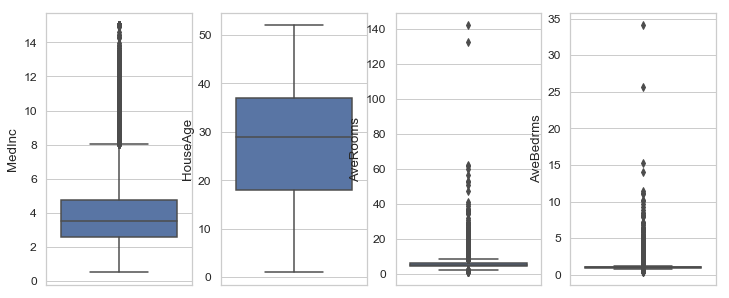

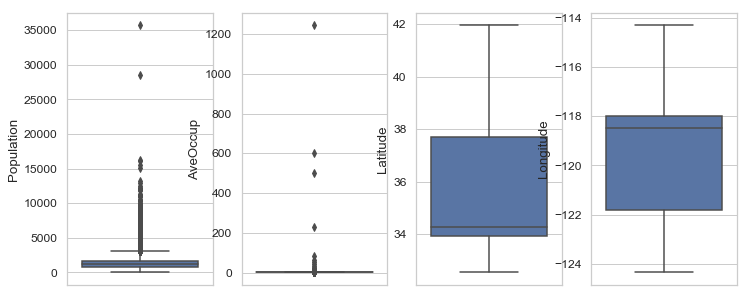

In [12]:
#check for the outliers in the data
fig, axs = plt.subplots(ncols = 4)
bx1 = sns.boxplot(x = california_df['MedInc'], orient = "v", ax = axs[0])
bx1.figure.set_size_inches(12,5)
bx2 = sns.boxplot(x = california_df['HouseAge'], orient = "v", ax = axs[1])
bx2.figure.set_size_inches(12,5)
bx3 = sns.boxplot(x = california_df['AveRooms'], orient = "v", ax = axs[2])
bx3.figure.set_size_inches(12,5)
bx4 = sns.boxplot(x = california_df['AveBedrms'], orient = "v", ax = axs[3])
bx4.figure.set_size_inches(12,5)

fig, axs = plt.subplots(ncols = 4)
bx5 = sns.boxplot(x = california_df['Population'], orient = "v", ax = axs[0])
bx5.figure.set_size_inches(12,5)
bx6 = sns.boxplot(x = california_df['AveOccup'], orient = "v", ax = axs[1])
bx6.figure.set_size_inches(12,5)
bx7 = sns.boxplot(x = california_df['Latitude'], orient = "v", ax = axs[2])
bx7.figure.set_size_inches(12,5)
bx8 = sns.boxplot(x = california_df['Longitude'], orient = "v", ax = axs[3])
bx8.figure.set_size_inches(12,5)

This shows there are no outliers for the three features: Latitude, Longitude, HouseAge. However, there are outliers present in all the other features. 

We know that standardization/normalizing data and also the MSE, RMSE metrics for regression problem is effected by outliers. First let us train the MLP model with outliers and see the MSE, RMSE score. Then we shall remove the outliers and train the model again to see its performance and make a comparison. Our expectation is that model without outliers perform well. Based on this we will tune the hyperparameters for the model (with/without outliers).

### **With outliers**

In [13]:
#input features
X = california_df.iloc[:,:-1]

#output feature
y = california_df["MedHouseValue"]

In [14]:
#check the shape of X
print("X shape:",X.shape)

X shape: (20640, 8)


In [15]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8)

In [16]:
#check the shape train and test data
print("Shape of X_train:",X_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_test:",y_test.shape)

Shape of X_train: (16512, 8)
Shape of y_train: (16512,)
Shape of X_test: (4128, 8)
Shape of y_test: (4128,)


In [17]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
X_train_df = pd.DataFrame(data = X_train, columns = california_data.feature_names)
X_test_df = pd.DataFrame(data = X_test, columns = california_data.feature_names)

In [19]:
#scaled X_train and X_test data
X_train_df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.337326,0.666667,0.035261,0.020511,0.037557,0.002852,0.516472,0.235060
1,0.212680,0.411765,0.021960,0.021192,0.083438,0.000713,0.574920,0.181275
2,0.151991,0.490196,0.016952,0.021970,0.052272,0.002468,0.163656,0.601594


In [20]:
#scaled X_train and X_test data
X_test_df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.329699,0.901961,0.025798,0.020079,0.023375,0.001239,0.556854,0.188247
1,0.066634,0.843137,0.025847,0.021268,0.028784,0.001273,0.701382,0.272908
2,0.145398,0.549020,0.018772,0.020635,0.055074,0.001772,0.151966,0.628486


In [21]:
#clear previous session to remove all the nodes left over from previous models, freeing memory and preventing slowdown and set seed
keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)

#set early stopping callback
es = EarlyStopping(monitor = 'val_loss', mode = "auto", verbose = 1, patience = 5)
optimizer = keras.optimizers.Adam(lr = 0.0001)

model = Sequential()
model.add(Dense(64,input_shape = (X_train_df.shape[1],), activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mae"])

model.summary()

%%time
#train the model 
history = model.fit(X_train, y_train,
                    epochs = epochs,
                    verbose = True,
                    shuffle = True,
                    validation_split = validation_split,
                    validation_steps = validation_steps,
                    steps_per_epoch = steps_per_epoch,
                    callbacks = [es])

#plot the train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#evaluate the model on test data
score = model.evaluate(X_test, y_test, verbose = True)
print("Test mse: {:.4f}".format(score[0]))
print("Test rmse: {:.4f}".format(math.sqrt(score[0])))
print("Test mae: {:.4f}".format(score[1]))

#print the predicted house prices for the test data
y_pred = model.predict(X_test)
print(y_pred)

sns.distplot(y_pred, label = "Predicted Values", hist = False)
sns.distplot(y_test, label = "Actual Values", hist = False)
plt.legend()#define parameters for the model
epochs = 50
train_batch = 64
validation_batch = 32

#split the training into 10% validation data
validation_split = 0.1 
steps_per_epoch = math.ceil((X_train.shape[0] * (1 - validation_split))/train_batch)
validation_steps = math.ceil((X_train.shape[0] * validation_split)/validation_batch)

In [22]:
#clear previous session to remove all the nodes left over from previous models, freeing memory and preventing slowdown and set seed
keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)

#set early stopping callback
es = EarlyStopping(monitor = 'val_loss', mode = "auto", verbose = 1, patience = 5)
optimizer = keras.optimizers.Adam(lr = 0.0001)

model = Sequential()
model.add(Dense(64,input_shape = (X_train_df.shape[1],), activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time
#train the model 
history = model.fit(X_train, y_train,
                    epochs = epochs,
                    verbose = True,
                    shuffle = True,
                    validation_split = validation_split,
                    validation_steps = validation_steps,
                    steps_per_epoch = steps_per_epoch,
                    callbacks = [es])

Epoch 1/50
233/233 [==============================] - 1s 3ms/step - loss: 4.1841 - mae: 1.6745 - val_loss: 3.1915 - val_mae: 1.3770
Epoch 2/50
233/233 [==============================] - 1s 2ms/step - loss: 2.1384 - mae: 1.0795 - val_loss: 1.5015 - val_mae: 0.9265
Epoch 3/50
233/233 [==============================] - 1s 2ms/step - loss: 1.3110 - mae: 0.8847 - val_loss: 1.2611 - val_mae: 0.8966
Epoch 4/50
233/233 [==============================] - 1s 2ms/step - loss: 1.1748 - mae: 0.8588 - val_loss: 1.1419 - val_mae: 0.8540
Epoch 5/50
233/233 [==============================] - 1s 2ms/step - loss: 1.0607 - mae: 0.8151 - val_loss: 1.0187 - val_mae: 0.8009
Epoch 6/50
233/233 [==============================] - 1s 2ms/step - loss: 0.9393 - mae: 0.7633 - val_loss: 0.8954 - val_mae: 0.7490
Epoch 7/50
233/233 [==============================] - 1s 2ms/step - loss: 0.8205 - mae: 0.7089 - val_loss: 0.7815 - val_mae: 0.6915
Epoch 8/50
233/233 [==============================] - 1s 3ms/step - loss: 0.

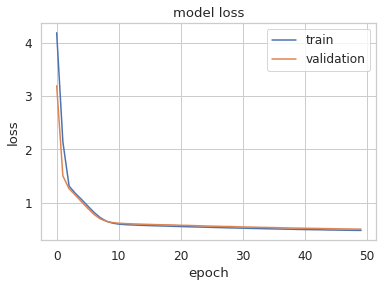

In [24]:
#plot the train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [25]:
#evaluate the model on test data
score = model.evaluate(X_test, y_test, verbose = True)
print("Test mse: {:.4f}".format(score[0]))
print("Test rmse: {:.4f}".format(math.sqrt(score[0])))
print("Test mae: {:.4f}".format(score[1]))

129/129 [==============================] - 0s 2ms/step - loss: 0.4673 - mae: 0.4998
Test mse: 0.4673
Test rmse: 0.6836
Test mae: 0.4998


In [26]:
#print the predicted house prices for the test data
y_pred = model.predict(X_test)
print(y_pred)

[[3.5160828 ]
 [0.58843756]
 [1.6364343 ]
 ...
 [1.991426  ]
 [2.1897306 ]
 [1.4868804 ]]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


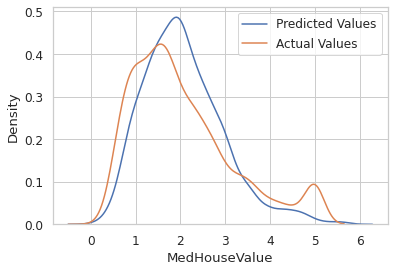

In [27]:
sns.distplot(y_pred, label = "Predicted Values", hist = False)
sns.distplot(y_test, label = "Actual Values", hist = False)
plt.legend()

**The MSE, MAE values are 0.4673 and 0.4998 respectively. This error is high which can be visualized in the graph above which is plotted with actual and predicted price values. The difference between the values are more.**

### **Without outliers**

In [28]:
#remove outliers using Quartiles and IQR
def remove_outlier(df):
    #calculate Q1, Q3 and IQR for the columns in the data
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    #remove outliers using IQR, Q1 and Q3
    df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis = 1)]

    return df

In [29]:
cali_df = california_df

In [39]:
#remove outlier
cali_df = remove_outlier(cali_df)

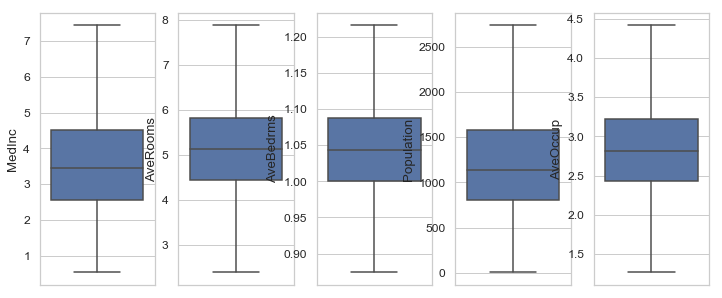

In [40]:
#check for the outliers in the data
fig, axs = plt.subplots(ncols = 5)
bx1 = sns.boxplot(x = cali_df['MedInc'], orient = "v", ax = axs[0])
bx1.figure.set_size_inches(12,5)
bx3 = sns.boxplot(x = cali_df['AveRooms'], orient = "v", ax = axs[1])
bx3.figure.set_size_inches(12,5)
bx4 = sns.boxplot(x = cali_df['AveBedrms'], orient = "v", ax = axs[2])
bx4.figure.set_size_inches(12,5)
bx5 = sns.boxplot(x = cali_df['Population'], orient = "v", ax = axs[3])
bx5.figure.set_size_inches(12,5)
bx6 = sns.boxplot(x = cali_df['AveOccup'], orient = "v", ax = axs[4])
bx6.figure.set_size_inches(12,5)

The dataset now has no outliers.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


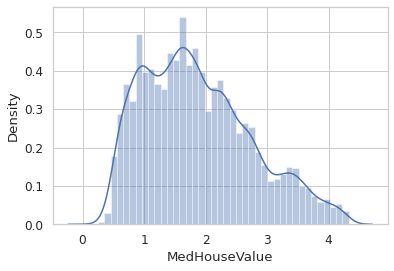

In [41]:
#MedHouseValue distribution after removing outliers
sns.distplot(cali_df['MedHouseValue'])

In [42]:
#input features
X1 = cali_df.iloc[:,:-1]

#output feature
y1 = cali_df["MedHouseValue"]

In [43]:
#check the shape of X
print("shape of X after removing outliers:",X1.shape)

shape of X after removing outliers: (14963, 8)


This shows roughly 4000+ outliers were present in the data that has been removed.

In [44]:
#split the data into train and test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 8)

In [45]:
#check the shape train and test data
print("Shape of X_train:",X_train1.shape)
print("Shape of y_train:",y_train1.shape)
print("Shape of X_test:",X_test1.shape)
print("Shape of y_test:",y_test1.shape)

Shape of X_train: (11970, 8)
Shape of y_train: (11970,)
Shape of X_test: (2993, 8)
Shape of y_test: (2993,)


In [46]:
#normaliza the data
sc = MinMaxScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

In [47]:
X_train_df1 = pd.DataFrame(data = X_train1, columns = california_data.feature_names)
X_test_df1 = pd.DataFrame(data = X_test1, columns = california_data.feature_names)

In [48]:
#define the model parameters 
steps_per_epoch1 = math.ceil((X_train1.shape[0] * (1 - validation_split))/train_batch)
validation_steps1 = math.ceil((X_train1.shape[0] * validation_split)/validation_batch)

In [53]:
#clear previous session to remove all the nodes left over from previous models, freeing memory and preventing slowdown and set seed
keras.backend.clear_session()
tf.random.set_seed(17)
np.random.seed(17)

model = Sequential()
model.add(Dense(64,input_shape = (X_train_df1.shape[1],), activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1))

#use the optimizer defined earlier in "with outliers" section
model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [54]:
%%time
#train the model 
history = model.fit(X_train1, y_train1,
                    epochs = epochs,
                    verbose = True,
                    shuffle = True,
                    validation_split = validation_split,
                    validation_steps = validation_steps1,
                    steps_per_epoch = steps_per_epoch1,
                    callbacks = [es])

Epoch 1/50
169/169 [==============================] - 0s 3ms/step - loss: 3.0220 - mae: 1.4921 - val_loss: 1.5927 - val_mae: 0.9934
Epoch 2/50
169/169 [==============================] - 0s 2ms/step - loss: 1.0299 - mae: 0.7814 - val_loss: 0.6946 - val_mae: 0.6722
Epoch 3/50
169/169 [==============================] - 0s 2ms/step - loss: 0.6961 - mae: 0.6697 - val_loss: 0.6274 - val_mae: 0.6465
Epoch 4/50
169/169 [==============================] - 0s 2ms/step - loss: 0.6303 - mae: 0.6377 - val_loss: 0.5633 - val_mae: 0.6111
Epoch 5/50
169/169 [==============================] - 0s 2ms/step - loss: 0.5755 - mae: 0.6077 - val_loss: 0.5125 - val_mae: 0.5816
Epoch 6/50
169/169 [==============================] - 0s 2ms/step - loss: 0.5256 - mae: 0.5787 - val_loss: 0.4592 - val_mae: 0.5483
Epoch 7/50
169/169 [==============================] - 0s 2ms/step - loss: 0.4669 - mae: 0.5426 - val_loss: 0.4013 - val_mae: 0.5073
Epoch 8/50
169/169 [==============================] - 0s 3ms/step - loss: 0.

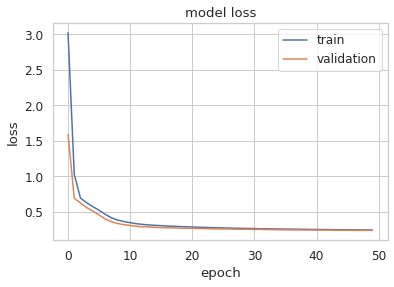

In [55]:
#plot the train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [56]:
#evaluate the model on test data
score1 = model.evaluate(X_test1, y_test1, verbose = True)
print("Test mse: {:.4f}".format(score1[0]))
print("Test rmse: {:.4f}".format(math.sqrt(score1[0])))
print("Test mae: {:.4f}".format(score1[1]))

94/94 [==============================] - 0s 2ms/step - loss: 0.2658 - mae: 0.3897
Test mse: 0.2658
Test rmse: 0.5156
Test mae: 0.3897


In [57]:
#print the predicted house prices for the test data
y_pred1 = model.predict(X_test1)
print(y_pred1[:10])

[[0.84780335]
 [1.8064873 ]
 [2.0133812 ]
 [3.5160685 ]
 [1.5984994 ]
 [2.6415405 ]
 [0.57227284]
 [2.293905  ]
 [1.1907032 ]
 [1.6796874 ]]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


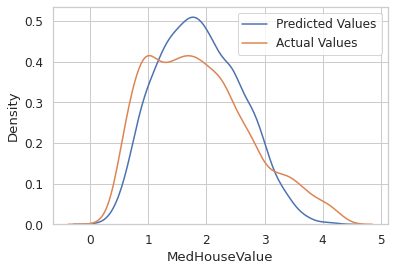

In [58]:
#plot the graph of actual and predicted values to see the variation in values
sns.distplot(y_pred1, label = "Predicted Values", hist = False)
sns.distplot(y_test1, label = "Actual Values", hist = False)
plt.legend()

**The MSE, MAE values are 0.2658 and 0.3697 respectively. This error is less compared to the model performed with outliers in the data. This is visualized in the graph above which is plotted with actual and predicted price values.**

Since the MSE, RMSE and MAE is less for this model after the outliers were removed, lets consider this model and tune the parameters to get a better MSE/MAE. 

### **Hyperparameter tuning with Keras Tuner**

The following parameters are used for the model tuning: 

1. Number of neurons
2. Number of layers: Upto 6 hidden layers, 2 dropout layers
3. Different activation functions: ReLU, Tanh, Sigmoid, LeakyReLU, SeLU
4. Different optimizers: SGD, RMSprop, Adam
4. Different learning rate: 0.001, 0.0001, 0.00001

The Keras Tuner library is used to perform hyperparameter tuning. This offers different tuning methods that are used to search for the best hyper parameters. Here I implement 2 such tuners to check for the best model and corresponding parameters. To implement this, the keras tuner is to be installed using the below command.

    !pip install -q -U keras-tuner


The hyper-parameter tuning is performed by defining the hypermodel. The model is implemented in the MLPModel.py file. The class implements a Deep MLP model that uses the following different functions available in the Keras Tuner to apply for pramater tuning:

   1. hp.Choice: Used to defined possible values for hidden_units, activation functions, dropout rates, learning rates
   2. hp.Int: Used to define the number of hidden layers for the model to be tuned. The range is defined from minimum 1 layer to a maximum of 4 layers

In [55]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 61kB 2.7MB/s 


In [56]:
#upload the models.py file
#un-comment the below line if the notebook is run in Google colab
#from google.colab import files
#model_file = list(files.upload().values())[0]

Saving MLPModel1.py to MLPModel1.py


In [57]:
#import the libraries
import kerastuner as kt
from kerastuner import HyperModel
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch, Hyperband
#un-comment the below line if the notebook is run in Google colab
#open('MLPModel.py','wb').write(model_file)
from MLPModel import DeepMLPModel

In [58]:
#class to clear the previous training output for the tuner search
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [59]:
#define the model parameters
input_shape = (X_train1.shape[1],)
#max trails for which the model is trained
max_trails = 15
#number of executions per trails
executions_per_trail = 2
seed = 5

#define learning rates for the optimizers
hp = HyperParameters()
hp.Choice('learning_rate', values=[0.001, 0.0001, 0.00001])

#initialize the hypermodel for the deep mlp model
hypermodel = DeepMLPModel(input_shape = input_shape)

The model is tuned using three tuners:

1. RandomSearch: The most intuitive way to perform hyperparameter tuning is to randomly sample hyperparameter combinations and test them. It chooses random values for the parameters from the given options and tries to minimize the objective function. 


2. HyperBand: The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.  The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer.

Two approches are used to study the MSE, MAE, RMSE values and to get the best model. 

### **RandomSearch**


In [60]:
#set the tuner to RandonSearch
tuner_rs = RandomSearch(hypermodel,
                        objective = 'val_loss',
                        hyperparameters = hp,
                        seed = seed,
                        max_trials = max_trails,
                        executions_per_trial = executions_per_trail,
                        overwrite = True)

#check the tuning parameters summary
tuner_rs.search_space_summary()

The search summary shows the parameters and their corresponding possible values that are defined to be tuned.

In [61]:
%%time
#set the epochs and start the tuner to search for the best model
n_epochs = 40
tuner_rs.search(X_train1, y_train1, epochs = n_epochs, validation_split = 0.1, verbose = True, callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit
CPU times: user 29min 24s, sys: 2min 58s, total: 32min 22s
Wall time: 26min 22s


The RandomSearch Tuner takes about 26mins to search for the best model.

In [62]:
#Show a summary of the search
tuner_rs.results_summary()

The summary results shows upto 10 best trails and the best model achieved a validation loss/validation MSE of 0.193 which is much less compared to the original model (0.2658).

In [63]:
#print the hyperparameters values
best_rs = tuner_rs.get_best_hyperparameters(num_trials = 1)[0]
print("learning_rate:",best_rs.get('learning_rate'))
print("Hidden units1:",best_rs.get('units_hidden1'))
print("Hidden units2:",best_rs.get('units_hidden2'))
print("Hidden units3:",best_rs.get('units_hidden3'))
print("dropout rate1:",best_rs.get('dropout1'))
print("dropout rate2:",best_rs.get('dropout2'))
print("dense_activation1:",best_rs.get('dense_activation1'))
print("dense_activation2:",best_rs.get('dense_activation2'))
print("dense_activation3:",best_rs.get('dense_activation3'))
print("num_layers:",best_rs.get('num_layers'))
print("optimizer:",best_rs.get('optimizer'))

learning_rate: 0.001
Hidden units1: 64
Hidden units2: 8
Hidden units3: 8
dropout rate1: 0.0
dropout rate2: 0.1
dense_activation1: relu
dense_activation2: relu
dense_activation3: relu
num_layers: 3
optimizer: rmsprop


The above parameter values are the best parameters selected using RandomSearch that gave a validation loss of 0.19. Using these parameters the model is built and trained to evaluate on the test data and to plot the learning curves.

In [64]:
#retrieve the best model
best_model_rs = tuner_rs.get_best_models(num_models = 1)[0]

In [65]:
#Build the model with the optimal hyperparameters
model_rs = tuner_rs.hypermodel.build(best_rs)
model_rs.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 7

In [66]:
%%time
#train it on the data
es = EarlyStopping(monitor = 'val_loss', mode = "auto", verbose = 1, patience = 10)
history_rs = model_rs.fit(X_train1, y_train1, 
                       epochs = 40, 
                       validation_split = 0.1)

Epoch 1/40
337/337 [==============================] - 1s 4ms/step - loss: 0.9823 - mae: 0.7443 - val_loss: 0.3602 - val_mae: 0.4665
Epoch 2/40
337/337 [==============================] - 1s 4ms/step - loss: 0.3499 - mae: 0.4534 - val_loss: 0.3123 - val_mae: 0.4225
Epoch 3/40
337/337 [==============================] - 1s 4ms/step - loss: 0.3081 - mae: 0.4195 - val_loss: 0.2908 - val_mae: 0.4055
Epoch 4/40
337/337 [==============================] - 1s 4ms/step - loss: 0.2908 - mae: 0.4062 - val_loss: 0.2699 - val_mae: 0.3889
Epoch 5/40
337/337 [==============================] - 1s 4ms/step - loss: 0.2795 - mae: 0.3964 - val_loss: 0.2496 - val_mae: 0.3776
Epoch 6/40
337/337 [==============================] - 1s 4ms/step - loss: 0.2676 - mae: 0.3878 - val_loss: 0.2595 - val_mae: 0.3800
Epoch 7/40
337/337 [==============================] - 1s 4ms/step - loss: 0.2635 - mae: 0.3835 - val_loss: 0.2715 - val_mae: 0.3810
Epoch 8/40
337/337 [==============================] - 1s 4ms/step - loss: 0.

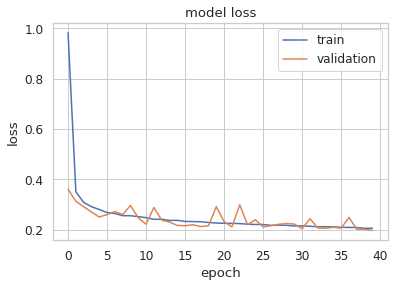

In [67]:
#plot the train and validation loss
plt.plot(model_rs.history.history['loss'])
plt.plot(model_rs.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [68]:
#evaluate the best model
score_rc = model_rs.evaluate(X_test1, y_test1)
print("Test mse: {:.4f}".format(score_rc[0]))
print("Test mae: {:.4f}".format(math.sqrt(score_rc[0])))
print("Test rmse: {:.4f}".format(score_rc[1]))

94/94 [==============================] - 0s 2ms/step - loss: 0.2196 - mae: 0.3328
Test mse: 0.2196
Test mae: 0.4686
Test rmse: 0.3328


In [69]:
#print the predicted house prices
y_pred_rc = model_rs.predict(X_test1)
print(y_pred_rc)

[[0.99082685]
 [1.2783415 ]
 [1.9569396 ]
 ...
 [1.8713404 ]
 [3.1184623 ]
 [2.2982655 ]]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


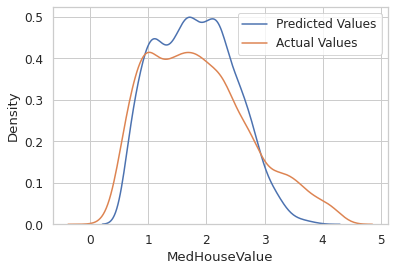

In [70]:
#plot the graph of actual and predicted values to see the variation in values
sns.distplot(y_pred_rc, label = "Predicted Values", hist = False)
sns.distplot(y_test1, label = "Actual Values", hist = False)
plt.legend()

**The MSE, MAE values are 0.2196 and 0.3327 respectively. This error is much less compared to the original model (MSE: 0.2658, MAE: 0.4998) . and the graph is plotted to show the actual and predicted price values.**

### **HyperBand Tuner**

In [72]:
%%time
max_epochs = 40

#set the tuner to Hyperband
tuner_hb = Hyperband(hypermodel,
                     hyperparameters = hp,
                     max_epochs = max_epochs,
                     objective = 'val_loss',
                     seed = 42,
                     executions_per_trial = executions_per_trail,
                     overwrite = True)

#start the tuner to search for the best model
tuner_hb.search(X_train1, y_train1, epochs = 40, validation_split = 0.1, verbose = True, callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit
CPU times: user 38min 5s, sys: 3min 30s, total: 41min 36s
Wall time: 34min 25s


In [73]:
#Show a summary of the search
tuner_hb.results_summary()

The summary results shows upto 10 best trails and the best model achieved a validation loss/validation MSE of 0.183 which is less compared to the original model (0.2658) and the RandomSearch Tuner (0.193). The HyperBand Tuner takes about 34mins to search as it is an optimized version of RandomSearch that performs early stopping and adaptive resource allocation during the model search. Though the time taken for tuning is more than the RandomSearch, it produces better results comparitively.

In [95]:
#print the hyperparameters values
best_hb = tuner_hb.get_best_hyperparameters(num_trials = 1)[0]
hb_epochs = best_hb.get('tuner/epochs')
print("learning_rate:",best_hb.get('learning_rate'))
print("Hidden units1:",best_hb.get('units_hidden1'))
print("Hidden units2:",best_hb.get('units_hidden2'))
print("Hidden units3:",best_hb.get('units_hidden3'))
print("dropout rate1:",best_hb.get('dropout1'))
print("dropout rate2:",best_hb.get('dropout2'))
print("dense_activation1:",best_hb.get('dense_activation1'))
print("dense_activation2:",best_hb.get('dense_activation2'))
print("dense_activation3:",best_hb.get('dense_activation3'))
print("num_layers:",best_hb.get('num_layers'))
print("optimizer:",best_hb.get('optimizer'))

learning_rate: 1e-05
Hidden units1: 128
Hidden units2: 32
Hidden units3: 8
dropout rate1: 0.2
dropout rate2: 0.1
dense_activation1: tanh
dense_activation2: relu
dense_activation3: relu
num_layers: 2
optimizer: rmsprop


The best model parameter values are as above and the model is evaluated to check for the test error and plot the learning curves.

In [75]:
#retrieve the best model
best_model_hb = tuner_hb.get_best_models(num_models = 1)[0]

In [76]:
mse_hb = best_model_hb.evaluate(X_test1, y_test1)[1]

94/94 [==============================] - 0s 2ms/step - loss: 0.2009 - mae: 0.3198


In [77]:
keras.backend.clear_session()
tf.random.set_seed(17)
np.random.seed(17)

# Build the model with the optimal hyperparameters and train it on the data
model_hb = tuner_hb.hypermodel.build(best_hb)
model_hb.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9

In [78]:
#train the model
history_hb = model_hb.fit(X_train1, y_train1, 
                       epochs = hb_epochs, 
                       validation_split = 0.1)

Epoch 1/40
337/337 [==============================] - 1s 4ms/step - loss: 0.4988 - mae: 0.5435 - val_loss: 0.2850 - val_mae: 0.3997
Epoch 2/40
337/337 [==============================] - 1s 3ms/step - loss: 0.3426 - mae: 0.4446 - val_loss: 0.2656 - val_mae: 0.3849
Epoch 3/40
337/337 [==============================] - 1s 3ms/step - loss: 0.3072 - mae: 0.4185 - val_loss: 0.2421 - val_mae: 0.3644
Epoch 4/40
337/337 [==============================] - 1s 3ms/step - loss: 0.2870 - mae: 0.4005 - val_loss: 0.2423 - val_mae: 0.3601
Epoch 5/40
337/337 [==============================] - 1s 4ms/step - loss: 0.2702 - mae: 0.3887 - val_loss: 0.2694 - val_mae: 0.4097
Epoch 6/40
337/337 [==============================] - 1s 4ms/step - loss: 0.2643 - mae: 0.3841 - val_loss: 0.2221 - val_mae: 0.3537
Epoch 7/40
337/337 [==============================] - 1s 4ms/step - loss: 0.2583 - mae: 0.3768 - val_loss: 0.2324 - val_mae: 0.3524
Epoch 8/40
337/337 [==============================] - 1s 3ms/step - loss: 0.

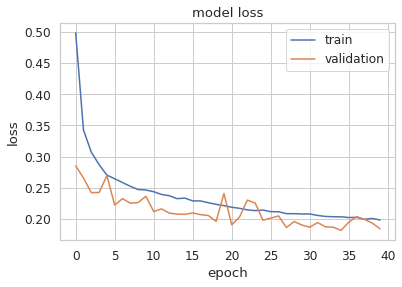

In [79]:
#plot the train and validation loss
plt.plot(model_hb.history.history['loss'])
plt.plot(model_hb.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [80]:
#evaluate the best model
score_hb = model_hb.evaluate(X_test1, y_test1)
print("Test mse: {:.4f}".format(score_hb[0]))
print("Test rmse: {:.4f}".format(math.sqrt(score_hb[0])))
print("Test mae: {:.4f}".format(score_hb[1]))

94/94 [==============================] - 0s 2ms/step - loss: 0.1990 - mae: 0.3147
Test mse: 0.1990
Test rmse: 0.4461
Test mae: 0.3147


In [81]:
#print the predicted house prices
y_pred_hb = model_hb.predict(X_test1)
print(y_pred_hb)

[[1.0455327]
 [1.143913 ]
 [2.016692 ]
 ...
 [1.9181702]
 [3.0467484]
 [2.4244606]]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


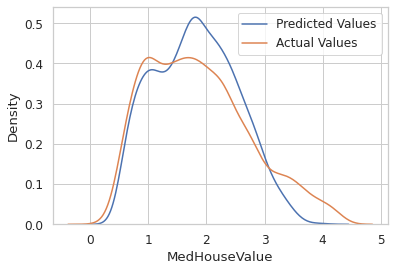

In [82]:
#plot the graph of actual and predicted values to see the variation in values
sns.distplot(y_pred_hb, label = "Predicted Values", hist = False)
sns.distplot(y_test1, label = "Actual Values", hist = False)
plt.legend()

**The MSE, MAE values are 0.199 and 0.3147 respectively. This error is much less compared to the RandomSearch model (MSE: 0.2196, MAE: 0.3327) and the original model (MSE: 0.2658, MAE: 0.4998).**

### **LeakyReLU and SeLU activation functions**

**LeakyReLU**

Finally for the best model achieved by HyperBand tuner, lets change the activation to LeakyRelu and check for the MSE, MAE.

In [96]:
#clear previous session to remove all the nodes left over from previous models, freeing memory and preventing slowdown and set seed
keras.backend.clear_session()
tf.random.set_seed(17)
np.random.seed(17)

#set early stopping callback
es = EarlyStopping(monitor = 'val_loss', mode = "auto", verbose = 1,patience=3)
optimizer = keras.optimizers.RMSprop(lr = 0.00001)

model = Sequential()
model.add(Dense(128,input_shape = (X_train_df1.shape[1],)))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))
model.add(Dense(8))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(1))

model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0

In [97]:
#train the model 
history = model.fit(X_train1, y_train1,
                    epochs = 40,
                    verbose = True,
                    shuffle = True,
                    validation_split = validation_split,
                    validation_steps = validation_steps1,
                    steps_per_epoch = steps_per_epoch1,
                    callbacks = [es])

Epoch 1/40
169/169 [==============================] - 1s 4ms/step - loss: 3.2015 - mae: 1.5461 - val_loss: 2.7611 - val_mae: 1.4094
Epoch 2/40
169/169 [==============================] - 1s 4ms/step - loss: 2.5898 - mae: 1.3428 - val_loss: 2.1636 - val_mae: 1.1948
Epoch 3/40
169/169 [==============================] - 1s 4ms/step - loss: 2.0144 - mae: 1.1409 - val_loss: 1.6183 - val_mae: 0.9984
Epoch 4/40
169/169 [==============================] - 1s 4ms/step - loss: 1.5209 - mae: 0.9637 - val_loss: 1.1769 - val_mae: 0.8451
Epoch 5/40
169/169 [==============================] - 1s 4ms/step - loss: 1.1437 - mae: 0.8280 - val_loss: 0.8781 - val_mae: 0.7402
Epoch 6/40
169/169 [==============================] - 1s 4ms/step - loss: 0.9267 - mae: 0.7576 - val_loss: 0.7420 - val_mae: 0.6962
Epoch 7/40
169/169 [==============================] - 1s 4ms/step - loss: 0.8373 - mae: 0.7312 - val_loss: 0.7044 - val_mae: 0.6853
Epoch 8/40
169/169 [==============================] - 1s 4ms/step - loss: 0.

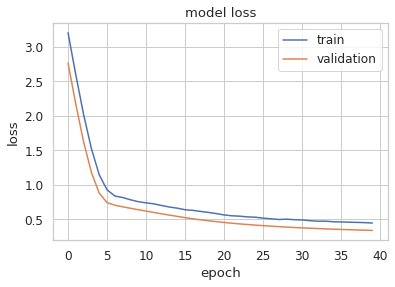

In [98]:
#plot the train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [99]:
#evaluate the model on test data
score_lr = model.evaluate(X_test1, y_test1, verbose = True)
print("Test mse: {:.4f}".format(score_lr[0]))
print("Test rmse: {:.4f}".format(math.sqrt(score_lr[0])))
print("Test mae: {:.4f}".format(score_lr[1]))

94/94 [==============================] - 0s 2ms/step - loss: 0.3816 - mae: 0.4804
Test mse: 0.3816
Test rmse: 0.6177
Test mae: 0.4804


In [100]:
#print the predicted house prices for the test data
y_pred_lr = model.predict(X_test1)
print(y_pred_lr[:10])

[[1.0440117]
 [2.2155044]
 [2.0355954]
 [3.1076694]
 [1.4865009]
 [2.1457152]
 [1.1892352]
 [1.8472728]
 [1.513683 ]
 [2.0168648]]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


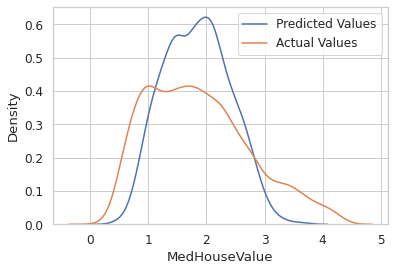

In [101]:
#plot the graph of actual and predicted values to see the variation in values
sns.distplot(y_pred_lr, label = "Predicted Values", hist = False)
sns.distplot(y_test1, label = "Actual Values", hist = False)
plt.legend()

**The MSE, MAE values are 0.3816 and 0.4804 respectively. This error is much high compared to the other models. This is evidently shown in the plot above as well. Thus LeakyReLU does not perform well as activation function for this regression dataset.**

**SeLU**

Finally for the best model achieved by HyperBand tuner, lets change the activation to SeLU and check for the MSE, MAE. To use SeLU activation function, we need to use LecunNormal initializer and Alpha Dropout layers instead of normal dropout layers. 

In [104]:
#clear previous session to remove all the nodes left over from previous models, freeing memory and preventing slowdown and set seed
keras.backend.clear_session()
tf.random.set_seed(17)
np.random.seed(17)

#set early stopping callback
es = EarlyStopping(monitor = 'val_loss', mode = "auto", verbose = 1,patience=3)
initializer = keras.initializers.LecunNormal(seed = 1)
optimizer = keras.optimizers.RMSprop(lr = 0.00001)

model = Sequential()
model.add(Dense(128,input_shape = (X_train_df1.shape[1],),activation = 'selu', kernel_initializer = initializer))
model.add(AlphaDropout(0.2))
model.add(Dense(32,activation = 'selu'))
model.add(Dense(32,activation = 'selu'))
model.add(AlphaDropout(0.1))
model.add(Dense(8,activation = 'selu'))
model.add(Dense(1))

model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9

In [105]:
#train the model 
history = model.fit(X_train1, y_train1,
                    epochs = 40,
                    verbose = True,
                    shuffle = True,
                    validation_split = validation_split,
                    validation_steps = validation_steps1,
                    steps_per_epoch = steps_per_epoch1)

Epoch 1/40
169/169 [==============================] - 1s 4ms/step - loss: 4.5279 - mae: 1.6915 - val_loss: 1.0720 - val_mae: 0.8291
Epoch 2/40
169/169 [==============================] - 1s 3ms/step - loss: 3.3392 - mae: 1.4395 - val_loss: 1.4723 - val_mae: 1.0191
Epoch 3/40
169/169 [==============================] - 1s 3ms/step - loss: 2.7800 - mae: 1.3144 - val_loss: 2.0960 - val_mae: 1.2529
Epoch 4/40
169/169 [==============================] - 1s 4ms/step - loss: 2.4209 - mae: 1.2369 - val_loss: 2.2226 - val_mae: 1.3030
Epoch 5/40
169/169 [==============================] - 1s 4ms/step - loss: 2.2242 - mae: 1.1879 - val_loss: 2.0774 - val_mae: 1.2595
Epoch 6/40
169/169 [==============================] - 1s 3ms/step - loss: 2.0972 - mae: 1.1518 - val_loss: 1.8581 - val_mae: 1.1859
Epoch 7/40
169/169 [==============================] - 1s 3ms/step - loss: 1.9137 - mae: 1.1003 - val_loss: 1.6394 - val_mae: 1.1089
Epoch 8/40
169/169 [==============================] - 1s 4ms/step - loss: 1.

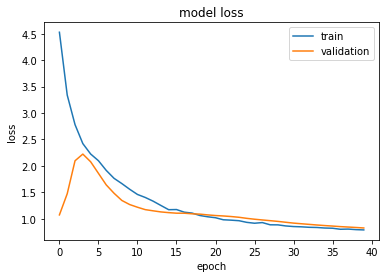

In [106]:
#plot the train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [107]:
#evaluate the model on test data
score_hb = model.evaluate(X_test1, y_test1, verbose = True)
print("Test mse: {:.4f}".format(score_hb[0]))
print("Test rmse: {:.4f}".format(math.sqrt(score_hb[0])))
print("Test mae: {:.4f}".format(score_hb[1]))

94/94 [==============================] - 0s 2ms/step - loss: 0.8217 - mae: 0.7641
Test mse: 0.8217
Test rmse: 0.9065
Test mae: 0.7641


In [108]:
#print the predicted house prices for the test data
y_pred_selu = model.predict(X_test1)
print(y_pred_selu[:10])

[[2.043217 ]
 [2.2166476]
 [2.2314541]
 [2.2941654]
 [2.142361 ]
 [2.1803956]
 [2.186785 ]
 [2.2061756]
 [2.203419 ]
 [2.2554986]]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


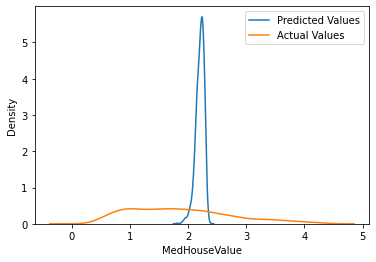

In [109]:
#plot the graph of actual and predicted values to see the variation in values
sns.distplot(y_pred_selu, label = "Predicted Values", hist = False)
sns.distplot(y_test1, label = "Actual Values", hist = False)
plt.legend()

**The MSE, MAE values are 0.8217 and 0.7641 respectively. This error is much higherg than all the other models and by the worst model. This is evidently shown in the graph plotted above as well. Thus SeLU does not perform well as activation function for this regression dataset.**

### **Tabulate the results**

In [28]:
data = {"model":["Baseline with Outliers", "Baseline without outliers", "RandomSearch Tuner", "HyperBand Tuner",
                 "Model with LeakyRelu activation","Model with SeLU activation"],
        "MSE":[0.4673, 0.2658, 0.2196, 0.1990, 0.3816, 0.8127],
        "RMSE":[0.6836, 0.5156, 0.4686, 0.4461, 0.6177, 0.9065],
        "MAE":[0.4998, 0.3897, 0.3328, 0.3147, 0.4804, 0.7641]}

pd.DataFrame(data = data)

,model,MSE,RMSE,MAE
0,Baseline with Outliers,0.4673,0.6836,0.4998
1,Baseline without outliers,0.2658,0.5156,0.3897
2,RandomSearch Tuner,0.2196,0.4686,0.3328
3,HyperBand Tuner,0.1990,0.4461,0.3147
4,Model with LeakyRelu activation,0.3816,0.6177,0.4804
5,Model with SeLU activation,0.8127,0.9065,0.7641


**From the table, the best model was selected by the HyperBand Tuner with MSE: 0.199, RMSE: 0.4461, MAE: 0.3147. The best model parameters are:**

    1. Number of hidden layers: 4
    2. Number of neurons in the layers: 128,32,32,8
    3. Dropout layers: 2 layers with 0.1 and 0.2 dropout rate
    4. Activation function: TanH for the first hidden layer, ReLU for the next other hidden layers
    5. Optimizer: RMSProp with lr = 1e-05
